# Divergent transcription validation

We want to validate the divergent identification dataset by comparing RNA-seq and K27Ac Chip-seq data from Rachez's dataset.

In [1]:
from pynextgen import divtrans
from pynextgen.bed import Bed
from pynextgen.basics_bam import Bam
import glob
import pandas as pd
from matplotlib import rcParams
import seaborn as sns

rcParams["figure.figsize"] = (16.0, 8.0)

In [2]:
%load_ext autoreload
%autoreload 2

## Input
Get mm9 genome size for fisher test:

In [3]:
%%bash

mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e "select chrom, size from mm9.chromInfo" \
    | sort -k1,1 -k2,2n > ../data/rachez_test_data/mm9.genome

In [3]:
chro_sizes = "../data/rachez_test_data/mm9.genome"

Bam files:

In [25]:
bams = glob.glob("../data/rachez_test_data/*.bam")
bams

['../data/rachez_test_data/HPg_1_Aligned.sortedByCoord.out.bam',
 '../data/rachez_test_data/HPg_3_Aligned.sortedByCoord.out.bam',
 '../data/rachez_test_data/HPg_2_Aligned.sortedByCoord.out.bam']

Subset test bam:

In [5]:
subset_bam = Bam(bams[0]).multi_fetch(["chr1:0-249250621"], bam_out="test.bam")

In [6]:
subset_bam

BAM Object for file: test.bam

## Generate bigwigs

In [7]:
%%bash

bamCoverage --bam test.bam  --filterRNAstrand forward -o test_forward.bw --region chr1:0:249250621
bamCoverage --bam test.bam  --filterRNAstrand reverse -o test_reverse.bw --region chr1:0:249250621

[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_load2] The index file is older than the data file: test.bam.bai
[W::hts_idx_

## Divergent transcription detection (test dataset)

In [8]:
test_analysis = divtrans.DivTransFromBam(
    subset_bam.path,
    distance=100,
    max_template_length=500,
    no_overlap=True,
    remove_GL_contigs=True,
)

In [9]:
test_analysis.run()

2019-04-03 09:48:34,491 -  - pynextgen.divtrans - _get_oriented_reads() - INFO - Bam: <pysam.libcalignmentfile.AlignmentFile object at 0x7f47a4e09948>; Number of alignments: 6,255,484; Secondary alignments removed: 302392; Too large templates removed: 2,627,818; Alignments with spliced reads removed: 147,406; Percentage of alignment used: 51%;


### Filtering

In [10]:
bedfilter = divtrans.BedFilter(test_analysis.bed, subset_bam.path, threads=4)

2019-04-03 09:48:38,533 -  - pynextgen.divtrans - __init__() - INFO - Intermediate files will be stored in /tmp/bedfilter_2cxo0am6


In [11]:
bedfilter.multiple_run(
    chro_sizes,
    flanks=[100, 250, 500],
    count_thress=[2, 5, 10],
    count_ratio_thress=[1, 2, 4],
)

2019-04-03 09:48:40,263 -  - pynextgen.divtrans - multiple_run() - INFO - Filtering <Bed object: test_divtrans>
 with params: flank:100; count_thres:2; count_ratio_thres:1
2019-04-03 09:48:40,314 - basics_bam.py - pynextgen.basics_bam - count_over_intervals() - INFO - Starting count on intervals
2019-04-03 09:48:46,248 - basics_bam.py - pynextgen.basics_bam - count_over_intervals() - INFO - Starting count on intervals
2019-04-03 09:48:52,493 -  - pynextgen.divtrans - _count_around_intervals() - INFO - Gathering stranded counts data ...
2019-04-03 09:48:52,525 -  - pynextgen.divtrans - _filter_by_counts() - INFO - Filtering intervals based on read coverage ...
2019-04-03 09:48:52,554 -  - pynextgen.divtrans - _filter_by_counts() - INFO - Filtering for <Bed object: test_divtrans>
 DONE.
2019-04-03 09:48:52,558 -  - pynextgen.divtrans - multiple_run() - INFO - Filtering <Bed object: test_divtrans>
 with params: flank:100; count_thres:2; count_ratio_thres:2
2019-04-03 09:48:52,562 -  - pyn

## Compare with K27Ac peaks

Using bed file with quality filtered peaks (select)

Rep2 was empty after quality filtering (apparently all peaks called before were noise)

In [16]:
ref_bed = Bed(
    "../data/rachez_test_data/H3K27ac_vs_INPUT-Mouse_Rep1_select_sort.narrowPeak"
).filter_by_chromosome("chr1")

### Statistics for parameter tuning:

#### True positive rate:

$TPR = TP/P$

With:
- TP: number of true positives
- P: number of real positive cases in the data

#### False positive rate:

$FPR = FP/N$

With:
- FP: number of false positives
- N: number of real negative cases in the data

Source:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [30]:
test_analysis.bed

<Bed object: test_divtrans>

In [34]:
divtrans_beds = list(bedfilter.filtered_beds.values()).append(test_analysis.bed)

In [17]:
jaccard_df = pd.concat(
    [bed.jaccard(ref_bed) for bed in bedfilter.filtered_beds.values()]
)
fisher_df = pd.concat(
    [bed.fisher(ref_bed, chro_sizes) for bed in bedfilter.filtered_beds.values()]
)

# To Compute the true positive ratio
len_df = pd.DataFrame(
    {bed.name: len(bed) for bed in bedfilter.filtered_beds.values()},
    index=["bed_length"],
).T

# To compute false positives
fp_df = pd.DataFrame(
    {
        bed.name: len(bed.intersect(ref_bed, supp_args="-v"))
        for bed in bedfilter.filtered_beds.values()
    },
    index=["false_positives"],
).T

# Total negative number is considered to be the number of intervals when complementing the K27Ac peaks
total_negatives = len(ref_bed.complement(chro_sizes))

# Join results
sum_df = pd.concat(
    [fisher_df.set_index("bed1"), jaccard_df.set_index("bed1"), len_df, fp_df],
    axis=1,
    sort=False,
).sort_values("jaccard", ascending=False)

# n_intersection from jaccard test can be assimilated to True Positives:
# ie (number of divergent transcription interval overlapping a K27Ac peak)
sum_df.rename(columns={"n_intersections": "true_positives"}, inplace=True)

# Compute true/false positive rate
sum_df["true_positive_rate"] = sum_df["true_positives"] / len(ref_bed)
sum_df["false_positive_rate"] = sum_df["false_positives"] / total_negatives

# Cannot compute the false positive rate.

# Table cleanup
sum_df.index = sum_df.index.str.replace("test_divtrans_", "")
sum_df.index = sum_df.index.str.replace("_counts_filtered", "")

In [21]:
sum_df.sort_values('true_positive_rate', ascending=False).head()

,left,right,two-tail,ratio,bed2,intersection,union-intersection,jaccard,true_positives,bed2,bed_length,false_positives,true_positive_rate,false_positive_rate
bed1,,,,,,,,,,,,,,
500_2_1,1.0,3.683000e-210,3.683000e-210,2094.506,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,2912,931262,0.003127,76,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,196,120,0.134276,0.199336
500_5_1,1.0,3.694300e-209,3.694300e-209,3696.540,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,2615,928395,0.002817,71,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,134,63,0.125442,0.104651
250_2_1,1.0,9.533300e-152,9.533300e-152,1497.720,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,2548,931235,0.002736,57,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,178,121,0.100707,0.200997
500_10_1,1.0,6.558500e-168,6.558500e-168,5306.991,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,2090,925147,0.002259,55,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,88,33,0.097173,0.054817
500_2_2,1.0,5.319100e-140,5.319100e-140,2205.671,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,2199,929216,0.002367,50,H3K27ac_vs_INPUT-Mouse_Rep1_select_sort_only_chr1,121,71,0.088339,0.117940


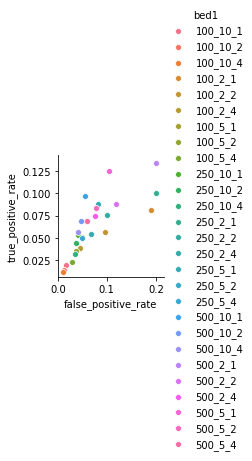

In [22]:
sns.pairplot(
    x_vars="false_positive_rate",
    y_vars="true_positive_rate",
    data=sum_df.reset_index(),
    hue="bed1",
)

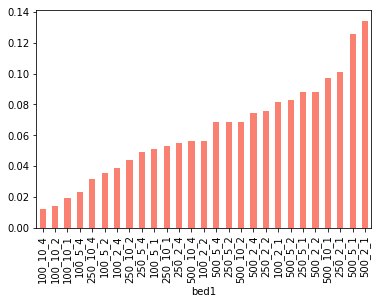

In [23]:
# Plot
sum_df["true_positive_rate"].sort_values().plot(kind="bar", color="salmon")

## Divergent transcription detection

In [9]:

analysis = [
    divtrans.DivTransFromBam(
        bam,
        distance=100,
        max_template_length=500,
        no_overlap=True,
        remove_GL_contigs=True,
    )
    for bam in bams
]

In [10]:
[an.run() for an in analysis]

2019-03-21 15:16:47,280 -  - pynextgen.divtrans - run() - INFO - Using already available bed file: ../data/rachez_test_data/HPg_1_Aligned.sortedByCoord.out_divtrans.bed
2019-03-21 15:16:47,280 -  - pynextgen.divtrans - run() - INFO - Using already available bed file: ../data/rachez_test_data/HPg_1_Aligned.sortedByCoord.out_divtrans.bed
2019-03-21 15:16:47,285 -  - pynextgen.divtrans - run() - INFO - Using already available bed file: ../data/rachez_test_data/HPg_3_Aligned.sortedByCoord.out_divtrans.bed
2019-03-21 15:16:47,285 -  - pynextgen.divtrans - run() - INFO - Using already available bed file: ../data/rachez_test_data/HPg_3_Aligned.sortedByCoord.out_divtrans.bed
2019-03-21 15:16:47,289 -  - pynextgen.divtrans - run() - INFO - Using already available bed file: ../data/rachez_test_data/HPg_2_Aligned.sortedByCoord.out_divtrans.bed
2019-03-21 15:16:47,289 -  - pynextgen.divtrans - run() - INFO - Using already available bed file: ../data/rachez_test_data/HPg_2_Aligned.sortedByCoord.out

[None, None, None]

## Divergent transcription bed filtering

In [13]:
divtrans.BedFilter(analysis[0].bed, bams[0], threads=4).run(
    chro_sizes, flank=500, count_thres=5, count_ratio_thres=2
)

2019-03-21 15:17:42,438 -  - pynextgen.divtrans - __init__() - INFO - Intermediate files will be stored in /tmp/tmp1pcspd7d
2019-03-21 15:17:42,438 -  - pynextgen.divtrans - __init__() - INFO - Intermediate files will be stored in /tmp/tmp1pcspd7d
2019-03-21 15:17:43,042 - basics_bam.py - pynextgen.basics_bam - count_over_intervals() - INFO - Starting count on intervals
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-4:


KeyboardInterrupt: 

  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/khourhin/programs/miniconda3/envs/classic/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/khourhin/programs/miniconda3/envs/class

## Compare with K27Ac Chip peaks

In [40]:
rep1_k27ac = Bed(
    "../data/rachez_test_data/H3K27ac_Rep1_vs_INPUT-Mouse_Rep1_peaks.narrowPeak"
)
rep2_k27ac = Bed(
    "../data/rachez_test_data/H3K27ac_Rep1_vs_INPUT-Mouse_Rep1_peaks.narrowPeak"
)
k27ac_vs_input = Bed(
    "../data/rachez_test_data/H3K27ac_vs_INPUT-Mouse_Rep1_select.narrowPeak"
).sort()

In [46]:
analysis[0].bed.sort().fisher(rep2_k27ac, "../data/rachez_test_data/mm9.genome")

{'left': 0.0,
 'right': 1.0,
 'two-tail': 0.0,
 'ratio': 18.238,
 'bed1': 'HPg_1_Aligned.sortedByCoord.out_divtrans_S',
 'bed2': 'H3K27ac_Rep1_vs_INPUT-Mouse_Rep1_peaks'}